# Extract MODIS cloud mask dataset 

Requirements: 

- A GOOGLE cloud project linked to your GOOGLE account


### My project 

Google account: gelieza.gk@gmail.com


cloud project ID: sample-project-452812 


cloud project name: Sample Project


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap
import math
import datetime
import pytz


In [2]:
# Authorization and initialization of the GEE
# OBS: You must create our own project on Google
# Authenticate Earth Engine
ee.Authenticate()
#
# Initialize Earth Engine
my_project_name = 'sample-project-452812' # use here the name of your own project on Google
ee.Initialize(project=my_project_name)

In [3]:
# Convert degree to radian
def deg2rad(deg):
    return deg * math.pi / 180

# Define the center of the bounding box (Bergen, Norway)
CENTER_LAT = 60.39
CENTER_LON = 5.33

# Approximate degree adjustments for 100km x 100km box
DEG_LAT_TO_KM = 111.412  # 1 degree latitude at 60° converted to km (https://en.wikipedia.org/wiki/Latitude)
DEG_LON_TO_KM = 111.317 * math.cos(deg2rad(CENTER_LAT))  # 1 degree longitude converted to km
LAT_OFFSET = 12.5 / DEG_LAT_TO_KM  # ~10km north/south
LON_OFFSET = 12.5 / DEG_LON_TO_KM  # ~10km east/west (varies with latitude, approximation)

# Define the bounding box
BBOX = {
    "north": CENTER_LAT + LAT_OFFSET,
    "south": CENTER_LAT - LAT_OFFSET,
    "west": CENTER_LON - LON_OFFSET,
    "east": CENTER_LON + LON_OFFSET
}
# Geometry Rectangle of Form minLng, minLat, maxLng, maxLat
bergen_roi = ee.Geometry.Rectangle([BBOX["west"], BBOX["south"], BBOX["east"], BBOX["north"]])

Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=10)

# Add the geometry to the map
Map.addLayer(bergen_roi, {"color": "red"}, "Bergen ROI")

# Display the weather stations
stations = {
    "Fana - Stend": (60.261870, 5.302989),
    "Flesland Bergen": (60.292792, 5.222689),
    "Florida": (60.3833, 5.3333)
}

for name, (lat, lon) in stations.items():
    point = ee.Geometry.Point([lon, lat])
    Map.addLayer(point, {"color": "blue"}, name)

# Display the map
Map

Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [4]:
# Look at Sentinel data
s2 = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filterBounds(bergen_roi)
print("Number of Sentinel Images: ", s2.size().getInfo())
s2.first()

Number of Sentinel Images:  8317


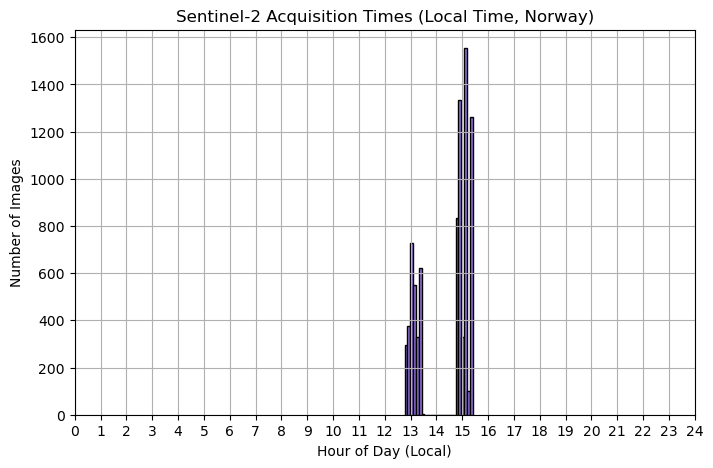

In [5]:
# Extract all timestamps
timestamps = s2.aggregate_array('system:time_start').getInfo()

# Convert to hour-of-day in LOCAL time (Norway, accounts for DST)
norway = pytz.timezone('Europe/Oslo')
hours_local = [norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).hour +
                norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).minute / 60.0
                for ts in timestamps]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(hours_local, bins=24, color='mediumpurple', edgecolor='black')
plt.title('Sentinel-2 Acquisition Times (Local Time, Norway)')
plt.xlabel('Hour of Day (Local)')
plt.ylabel('Number of Images')
plt.grid(True)
plt.xticks(range(0, 25))
plt.show()

In [33]:
l9_T1 = ee.ImageCollection("LANDSAT/LC09/C02/T1") \
    .filterBounds(bergen_roi) 
l9_T2 = ee.ImageCollection("LANDSAT/LC09/C02/T2") \
    .filterBounds(bergen_roi) 
l8_T1 = ee.ImageCollection("LANDSAT/LC08/C02/T1") \
    .filterBounds(bergen_roi) 
l8_T2 = ee.ImageCollection("LANDSAT/LC08/C02/T2") \
    .filterBounds(bergen_roi) 
l7_T1 = ee.ImageCollection("LANDSAT/LE07/C02/T1") \
    .filterBounds(bergen_roi)
l7_T2 = ee.ImageCollection("LANDSAT/LE07/C02/T2") \
    .filterBounds(bergen_roi)    
l5_T1 = ee.ImageCollection("LANDSAT/LT05/C02/T1") \
    .filterBounds(bergen_roi) 
l5_T2 = ee.ImageCollection("LANDSAT/LT05/C02/T2") \
    .filterBounds(bergen_roi) 
l4_T1 = ee.ImageCollection("LANDSAT/LT04/C02/T1") \
    .filterBounds(bergen_roi) 
l4_T2 = ee.ImageCollection("LANDSAT/LT04/C02/T2") \
    .filterBounds(bergen_roi) 
   
l4_9 = l8_T1.merge(l8_T2).merge(l9_T1).merge(l9_T2).merge(l7_T1).merge(l7_T2).merge(l5_T1).merge(l5_T2).merge(l4_T1).merge(l4_T2)
print("Number of Landsat Images: ", l4_9.size().getInfo())
l4_9.first()

Number of Landsat Images:  3975


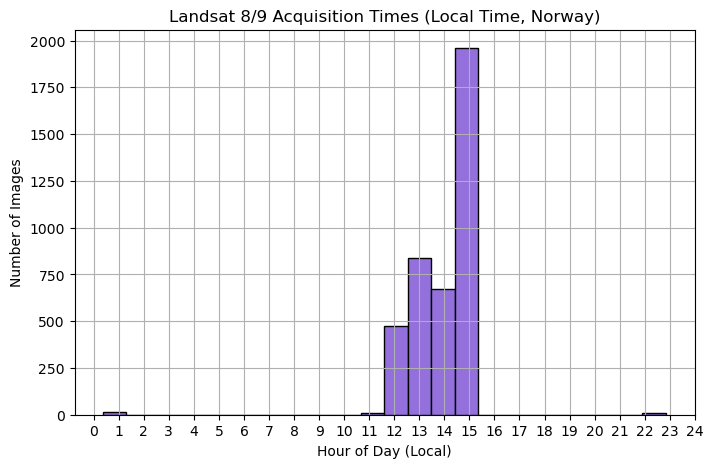

In [ ]:
# Extract all timestamps
timestamps = l4_9.aggregate_array('system:time_end').getInfo()

# Convert to hour-of-day in LOCAL time (Norway, accounts for DST)
norway = pytz.timezone('Europe/Oslo')
hours_local = [norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).hour +
                norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).minute / 60.0
                for ts in timestamps]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(hours_local, bins=24, color='mediumpurple', edgecolor='black')
plt.title('Landsat 8/9 Acquisition Times (Local Time, Norway)')
plt.xlabel('Hour of Day (Local)')
plt.ylabel('Number of Images')
plt.grid(True)
plt.xticks(range(0, 25))
plt.show()

In [6]:
# Visualize data coverage over different periods
# Helper function to extract date parts from system time
def add_time_properties(img):
    date = ee.Date(img.get('system:time_start'))
    year = date.get('year')
    month = date.get('month')
    doy = date.getRelative('day', 'year')
    season = month.expression(
        "(m <= 2 || m == 12) ? 0 : (m <= 5) ? 1 : (m <= 8) ? 2 : 3", # Winter = 0, Spring = 1, Summer = 2, Autumn = 3
        {'m': month}
    )
    return img.set({'year': year, 'month': month, 'doy': doy, 'season': season})

# Add time properties to each image
s2 = s2.map(add_time_properties)
s2.first()

In [7]:

# Get histograms 
hist_year = s2.aggregate_histogram("year").getInfo()
hist_month = s2.aggregate_histogram("month").getInfo()
hist_season = s2.aggregate_histogram("season").getInfo()
hist_doy = s2.aggregate_histogram("doy").getInfo()

# Convert keys to numeric
hist_month = {int(k) : v for k, v in hist_month.items()}
hist_doy = {int(k): v for k, v in hist_doy.items()}


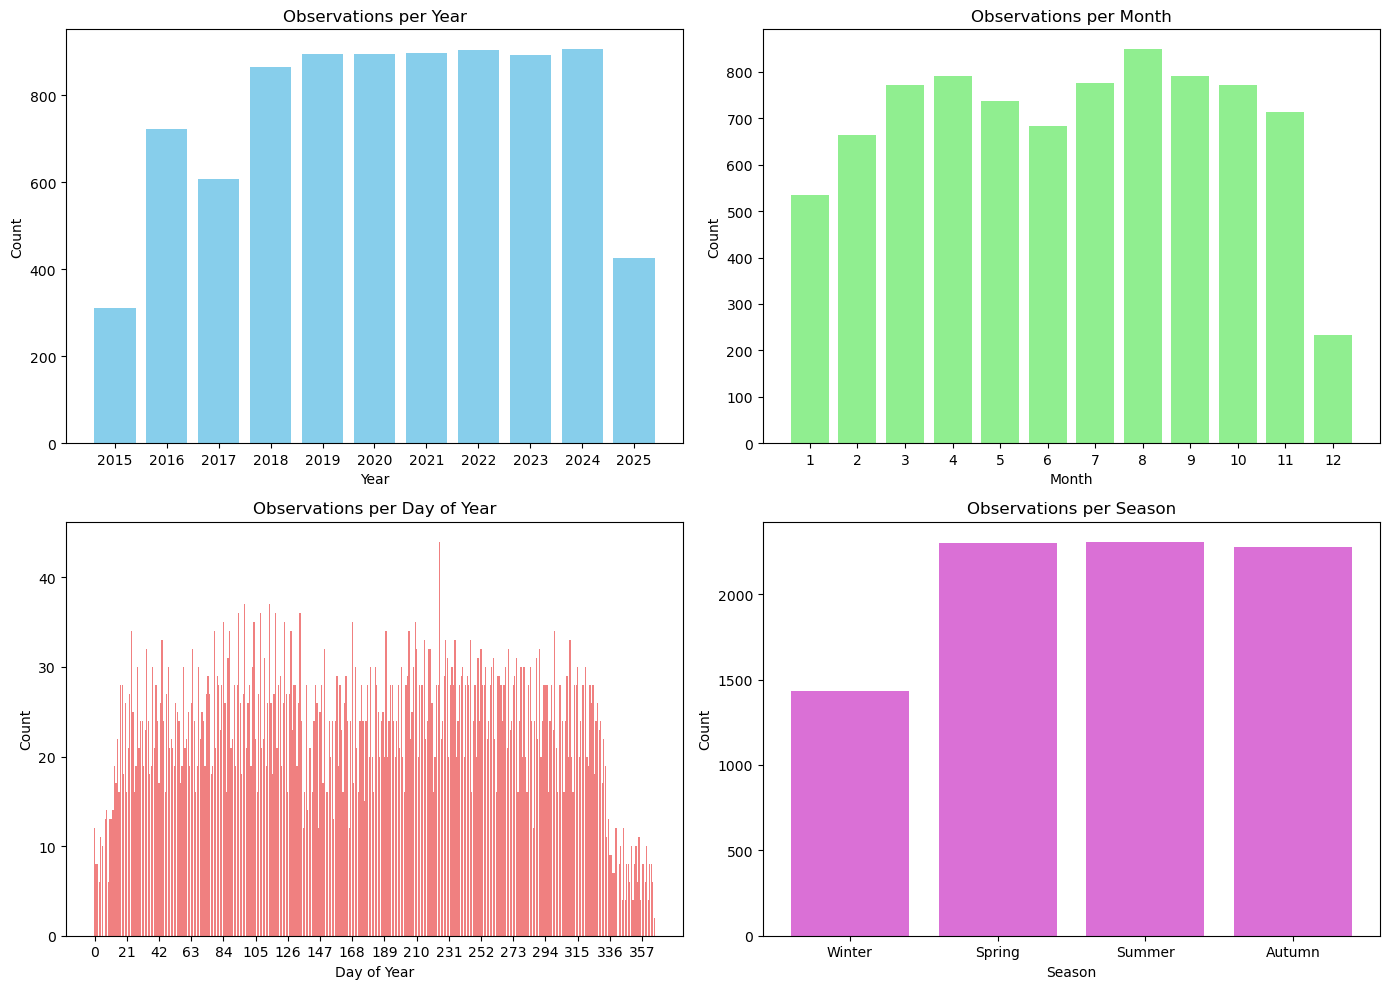

In [8]:

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].bar(hist_year.keys(), hist_year.values(), color='skyblue')
axs[0, 0].set_title('Observations per Year')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Count')

axs[0, 1].bar(hist_month.keys(), hist_month.values(), color='lightgreen')
axs[0, 1].set_title('Observations per Month')
axs[0, 1].set_xlabel('Month')
axs[0,1].set_xticks(range(1,13))
axs[0, 1].set_ylabel('Count')

axs[1, 0].bar(hist_doy.keys(), hist_doy.values(), color='lightcoral')
axs[1, 0].set_title('Observations per Day of Year')
axs[1, 0].set_xlabel('Day of Year')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xticks([k for k in hist_doy.keys() if k % 21 == 0])


axs[1, 1].bar(hist_season.keys(), hist_season.values(), color='orchid')
axs[1, 1].set_title('Observations per Season')
axs[1, 1].set_xlabel('Season')
axs[1, 1].set_ylabel('Count')
axs[1,1].set_xticklabels(["Winter", "Spring", "Summer", "Autumn"])

plt.tight_layout()
plt.show()

In [9]:
# Nested dict for year-month
years = range(2015, 2026)
months = range(1,13)
hist_year_month = {year : {m : 0 for m in months} for year in years}

for year in years: 
    s2_year = s2.filter(ee.Filter.eq('year', year))
    year_month_counts = s2_year.aggregate_histogram("month").getInfo()
    for month, count in year_month_counts.items(): 
        hist_year_month[year][int(month)] = count
    print("hist year ", year, ": ", hist_year_month[year])

hist year  2015 :  {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 43, 8: 134, 9: 73, 10: 20, 11: 38, 12: 3}
hist year  2016 :  {1: 22, 2: 38, 3: 50, 4: 74, 5: 64, 6: 72, 7: 82, 8: 78, 9: 80, 10: 92, 11: 70, 12: 0}
hist year  2017 :  {1: 17, 2: 39, 3: 39, 4: 39, 5: 39, 6: 48, 7: 83, 8: 73, 9: 75, 10: 82, 11: 72, 12: 2}
hist year  2018 :  {1: 50, 2: 70, 3: 85, 4: 83, 5: 82, 6: 85, 7: 87, 8: 80, 9: 81, 10: 82, 11: 76, 12: 3}
hist year  2019 :  {1: 48, 2: 75, 3: 81, 4: 82, 5: 75, 6: 84, 7: 83, 8: 80, 9: 82, 10: 87, 11: 78, 12: 39}
hist year  2020 :  {1: 64, 2: 78, 3: 80, 4: 84, 5: 84, 6: 83, 7: 80, 8: 82, 9: 81, 10: 76, 11: 73, 12: 29}
hist year  2021 :  {1: 67, 2: 72, 3: 83, 4: 78, 5: 82, 6: 77, 7: 78, 8: 82, 9: 78, 10: 82, 11: 79, 12: 39}
hist year  2022 :  {1: 70, 2: 73, 3: 80, 4: 79, 5: 82, 6: 78, 7: 78, 8: 82, 9: 77, 10: 84, 11: 77, 12: 43}
hist year  2023 :  {1: 66, 2: 73, 3: 86, 4: 74, 5: 82, 6: 78, 7: 79, 8: 75, 9: 84, 10: 83, 11: 74, 12: 39}
hist year  2024 :  {1: 68, 2: 74, 3: 82, 4: 74

{2015: {1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 43,
  8: 134,
  9: 73,
  10: 20,
  11: 38,
  12: 3},
 2016: {1: 22,
  2: 38,
  3: 50,
  4: 74,
  5: 64,
  6: 72,
  7: 82,
  8: 78,
  9: 80,
  10: 92,
  11: 70,
  12: 0},
 2017: {1: 17,
  2: 39,
  3: 39,
  4: 39,
  5: 39,
  6: 48,
  7: 83,
  8: 73,
  9: 75,
  10: 82,
  11: 72,
  12: 2},
 2018: {1: 50,
  2: 70,
  3: 85,
  4: 83,
  5: 82,
  6: 85,
  7: 87,
  8: 80,
  9: 81,
  10: 82,
  11: 76,
  12: 3},
 2019: {1: 48,
  2: 75,
  3: 81,
  4: 82,
  5: 75,
  6: 84,
  7: 83,
  8: 80,
  9: 82,
  10: 87,
  11: 78,
  12: 39},
 2020: {1: 64,
  2: 78,
  3: 80,
  4: 84,
  5: 84,
  6: 83,
  7: 80,
  8: 82,
  9: 81,
  10: 76,
  11: 73,
  12: 29},
 2021: {1: 67,
  2: 72,
  3: 83,
  4: 78,
  5: 82,
  6: 77,
  7: 78,
  8: 82,
  9: 78,
  10: 82,
  11: 79,
  12: 39},
 2022: {1: 70,
  2: 73,
  3: 80,
  4: 79,
  5: 82,
  6: 78,
  7: 78,
  8: 82,
  9: 77,
  10: 84,
  11: 77,
  12: 43},
 2023: {1: 66,
  2: 73,
  3: 86,
  4: 74,
  5: 82,
  6: 78,
  7: 

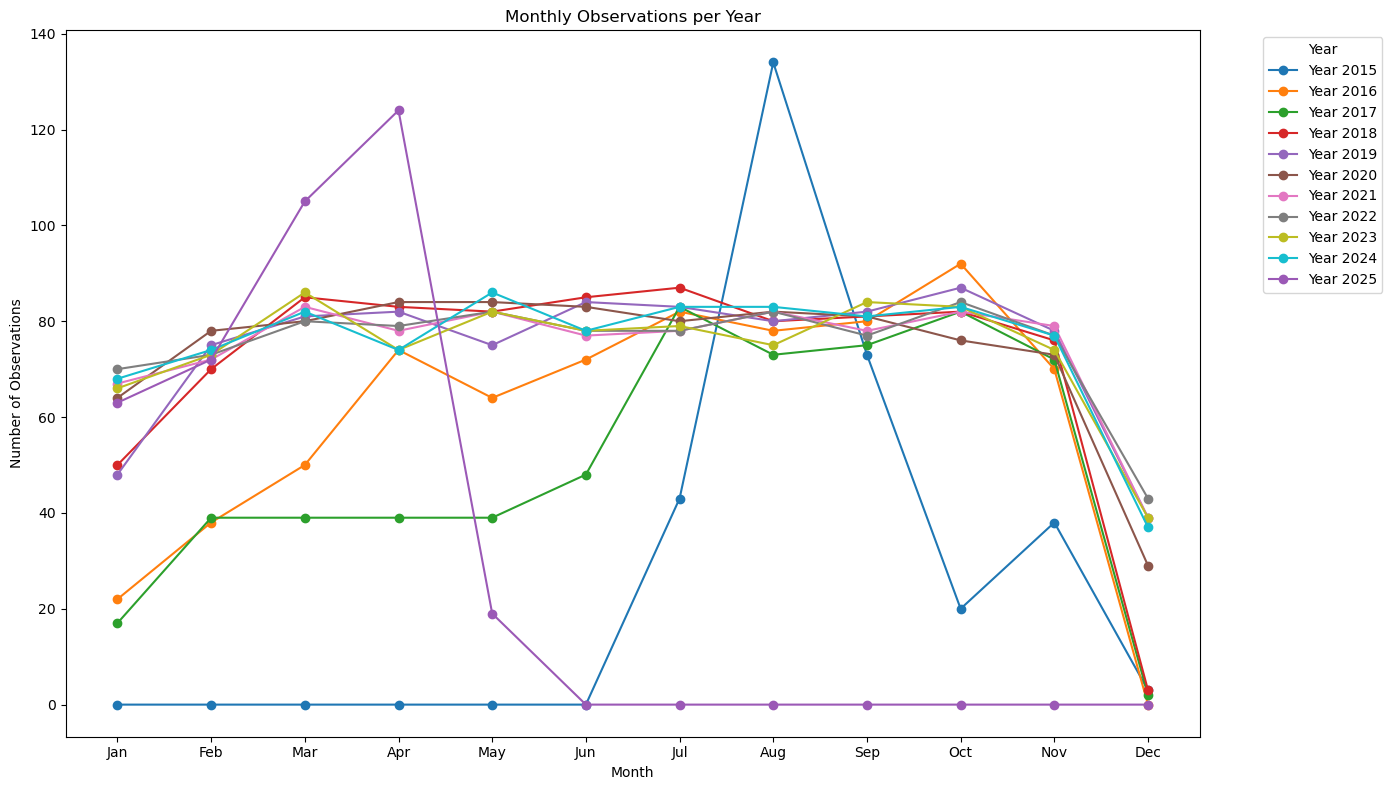

In [10]:
# Plot the observations per month for each year
fig, ax = plt.subplots(figsize=(14, 8))
months = range(1,13)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#9b59b6', '#f39c12']

for idx, year in enumerate(years):
    ax.plot(months, hist_year_month[year].values(), label=f'Year {year}', color=colors[idx], marker='o')

ax.set_title('Monthly Observations per Year')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Observations')
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
# Any invalid data? data should be within 0 to 100 

# Binary mask for cloud with 
CLD_PRB_THRESH = 50 # turn int data to binary using different thresholds

def add_cloud_mask(image):
    cloud_mask = image.select('probability').gt(CLD_PRB_THRESH).rename('cloud_mask')
    return image.addBands(cloud_mask)

def add_constant(image): 
    valid_pixel = image.select('probability').gt(0).rename('valid_pixel')
    return image.addBands(valid_pixel)

s2 = s2.map(add_cloud_mask)
s2 = s2.map(add_constant)
s2.first()

In [43]:
image = ee.Image('COPERNICUS/S2_CLOUD_PROBABILITY/20150729T110026_20150729T110029_T32VKM')
image = add_cloud_mask(image)
image = add_constant(image)

cloud_mask = image.select('cloud_mask').eq(1)

print(image.bandNames().getInfo())     # Should only be ['constant']
print(cloud_mask.bandNames().getInfo())   # Should only be ['cloud_mask']

# 5. Use weighted sum to count valid pixels in the region
total_pixels = image.select('valid_pixel').reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=bergen_roi,
    scale=10,
    maxPixels=1e9
).get('valid_pixel')

# Count cloudy pixels (value = 1)
cloudy_pixels = cloud_mask.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=bergen_roi,
    scale=10,
    maxPixels=1e9
).get('cloud_mask')  # server-side ee.Number

# 6. Print the result
print('Total valid pixels (weighted):', total_pixels.getInfo())
print('Cloudy pixels (weighted): ', cloudy_pixels.getInfo())
print('coverage : ', cloudy_pixels.getInfo()/total_pixels.getInfo())

['probability', 'cloud_mask', 'valid_pixel']
['cloud_mask']
Total valid pixels (weighted): 1892614.8039215687
Cloudy pixels (weighted):  1202440.701960782
coverage :  0.6353330320936305


In [44]:
def add_cloud_cover(img):
    # Assume cloud_mask is a binary mask: 1 = cloud, 0 = clear
    cloud_mask = img.select('cloud_mask').eq(1)

    # Count total pixels 
    total_pixels = img.select('valid_pixel').reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=bergen_roi,
        scale=10,
        maxPixels=1e9
    ).get('valid_pixel')

    # Count cloudy pixels (value = 1)
    cloudy_pixels = cloud_mask.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=bergen_roi,
        scale=10,
        maxPixels=1e9
    ).get('cloud_mask')  
    
    avg_prob = img.select('probability').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=bergen_roi,
        scale=10,
        maxPixels=1e9
    ).get('probability')

    # Calculate cloud cover % - Avoid division by zero
    cloud_cover = ee.Number(cloudy_pixels).divide(ee.Number(total_pixels)).multiply(100)
        
    # Attach as image property
    return img.set({'cloud_cover': cloud_cover.round(), # round to nearest integer
                    'cloudy_pixels': cloudy_pixels,
                    'total_pixels': total_pixels,
                    'avg_cloud_prob': avg_prob}) 


s2 = s2.map(add_cloud_cover)
s2.first()

In [45]:
# Convert to feature for export 

def img_to_feature(img): 
    return ee.Feature(None, {'cloud_cover': img.get('cloud_cover'), 
                             'cloudy_pixels': img.get('cloudy_pixels'),
                             'total_pixels': img.get('total_pixels'),
                             'avg_cloud_prob': img.get('avg_cloud_prob'),
                             'doy': img.get('doy'),
                             'year': img.get('year'), 
                             'month': img.get('month'),
                             'season': img.get('season'),
                             'system:index': img.get('system:index'),
                             'system:time_start' : img.get('system:time_start'),
                             'system:time_end': img.get('system:time_end')})
    
cloud_cover_f_collection = s2.map(img_to_feature)

# Export task to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=cloud_cover_f_collection,
    description='s2_cloud_cover',
    fileFormat='CSV'
)

# Start the export task
task.start()

In [ ]:
# High resolution cloud frequency map 
# All time aggregate: What is the general spatial probability of a cloud in some area? 
# Preserve the infrastructural/geological/administrative borders for orientation

# Aggregate for each month/season and plot the same image 

# 